In [252]:
import numpy as np 
import pandas as pd 
from utils import * 
from src.files import BLASTJsonFile,MASTXMLFile 
import subprocess
from tqdm import tqdm
import os
from Bio import Entrez 
import xml
import glob
import re
from Bio.Seq import Seq
import matplotlib.pyplot as plt 
from src.data import * 
import matplotlib as mpl
from matplotlib.patches import Rectangle, Patch
import time
import seaborn as sns

Entrez.email = 'prichter@berkeley.edu'
data_dir = '../data/data-2'

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
# First get all proteins annotated as VirC1 in the NCBI database. 
# esearch -db protein -query "VirC1" | efetch -format acc
virc1_ids = pd.read_csv('../data/data-2/virc1_ids.txt', header=None, names=['id']).values.ravel()

In [255]:
def get_nuccore_links(protein_id):
    handle = Entrez.elink(dbfrom='protein', db='nuccore', id=protein_id, retmax=1, retmode='xml')
    tree = xml.etree.ElementTree.fromstring(handle.read())
    links = [link.find('Id').text for link in tree.findall('**/Link')]
    return links

def get_protein_info(protein_id:str):
    handle = Entrez.efetch(db='protein', id=protein_id, retmode='xml')
    tree = xml.etree.ElementTree.fromstring(handle.read())

    info = {'protein_id':protein_id}
    info['taxonomy'] = tree.find('.//*/GBSeq_taxonomy').text
    info['seq'] = tree.find('.//*/GBSeq_sequence').text.upper()
    return info

def get_assembly_link(nuccore_id):
    handle = Entrez.elink(dbfrom='nuccore', db='assembly', id=nuccore_id, retmax=1, retmode='xml')
    tree = xml.etree.ElementTree.fromstring(handle.read())
    links = [link.find('Id').text for link in tree.findall('**/Link')]
    if len(links) == 0:
        # print(f'get_assembly_link: No assembly link for nuccore ID {nuccore_id}')
        return None
    return links[-1]

def get_ncbi_data(virc1_ids, path:str='../data/data-2/virc1.csv'):

    dfs = list()
    if os.path.exists(path):
        dfs.append(pd.read_csv(path, index_col=0))
        virc1_ids = [id_ for id_ in virc1_ids if (id_ not in dfs[0].index)]

    try:
        df = list()
        # virc1_ids = [','.join(chunk) for chunk in np.array_split(virc1_ids, 100)]
        for id_ in tqdm(virc1_ids, desc='get_ncbi_data'):

            row = get_protein_info(id_)

            try:
                links = get_nuccore_links(id_)
                for link in links:
                    handle = Entrez.esummary(db='nuccore', id=link, retmode='xml')
                    tree = xml.etree.ElementTree.fromstring(handle.read())

                    row['nuccore_id'] = tree.find('.//Item[@Name="Caption"]').text
                    row['title'] = tree.find('.//Item[@Name="Title"]').text
                    row['assembly_link'] = get_assembly_link(row['nuccore_id'])
                    row['nuccore_link'] = link

                    if row['assembly_link'] is not None:
                        handle = Entrez.esummary(db='assembly', id=row['assembly_link'], retmode='xml')
                        tree = xml.etree.ElementTree.fromstring(handle.read())
                        assembly_id = tree.find('**/AssemblyAccession')
                        row['assembly_id'] = assembly_id.text if (assembly_id is not None) else 'none'
                        row['organism'] = tree.find('**/Organism').text

                    df.append(row.copy())
                    time.sleep(3)
                    
            except Exception as err:
                df.append(row) # Add the protein information even if there is an exception. 
                print(f'get_ncbi_data: An error occurred, {err}.')
                break
    except:
        pass
        
    if len(df) == 0:
        print('get_ncbi_data: No data added.')
    else:
        dfs.append(pd.DataFrame(df).set_index('protein_id'))

    df = pd.concat(dfs)
    df.to_csv(path)
    print(f'get_ncbi_data: NCBI data written to {path}.')

# get_ncbi_data(virc1_ids)


In [256]:
def get_assembly(assembly_ids:list, assembly_dir:str=None):
    assembly_ids = ','.join(assembly_ids)
    cmd = f'datasets download genome accession {assembly_ids} --include genome'
    subprocess.run(cmd, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(f'unzip -o ncbi_dataset.zip -d {assembly_dir}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL) # Unzip and overwrite existing files. 

get_genome_id = lambda file_name : re.search(r'GC[AF]_\d+\.\d+', file_name).group(0)

def get_sequences(ncbi_df:pd.DataFrame, nuccore_dir:str='../data/data-2/ncbi/nuccore', assembly_dir:str='../data/data-2/ncbi/assembly'):

    assembly_ids = ncbi_df.assembly_id.dropna().unique()
    nuccore_ids = ncbi_df[ncbi_df.assembly_id.isnull()].nuccore_id.unique()

    for id_ in tqdm(nuccore_ids, desc='get_sequences: Downloading nucleotide sequences.'):
        path = os.path.join(nuccore_dir, f'{id_}.1.fn')
        if os.path.exists(path):
            continue 
        handle = Entrez.efetch(db='nuccore', id=id_, rettype='fasta', retmode='text')
        with open(path, 'w') as f:
            f.write(handle.read())
    
    downloaded_assembly_ids = [os.path.basename(path).replace('.fn', '') for path in glob.glob(os.path.join(assembly_dir, '*'))]
    assembly_ids = [id_ for id_ in assembly_ids if (id_ not in downloaded_assembly_ids)] # Don't re-download assemblies.
    assembly_ids = np.array_split(assembly_ids, 50) # Download assembly IDs in chunks. 
    assembly_ids = [ids for ids in assembly_ids if len(ids) > 0]

    for ids in tqdm(assembly_ids, desc='get_sequences: Downloading assemblies.'):
        get_assembly(ids, assembly_dir=assembly_dir)

    # Unpack the downloaded NCBI assemblies.
    for path in glob.glob(f'{assembly_dir}/**/*.fna', recursive=True):
        genome_id = get_genome_id(path)
        subprocess.run(f'mv {path} ../data/data-2/ncbi/assembly/{genome_id}.fn', shell=True, check=True)

# get_sequences(df)
    

In [257]:
for path in tqdm(glob.glob('../data/data-2/ncbi/**/*.fn'), 'Running HMM...'):
    source_id = os.path.basename(path).replace('.fn', '')
    output_path = f'../data/data-2/hmmer/{source_id}.tsv'
    if not os.path.exists(output_path):
        try:
            # Default HMMer E-value threshold is 10. 
            cmd = f'nhmmer -E 10 --tblout {output_path} ../data/data-1/hmms/library.hmm {path}'
            subprocess.run(cmd, shell=True, check=True, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        except:
            print(f'HMMer could not be run for sequence {source_id}, the file is probably empty.')


Running HMM...: 100%|██████████| 1778/1778 [00:00<00:00, 51995.62it/s]

HMMer could not be run for sequence CAIIUG000000000.1, the file is probably empty.
HMMer could not be run for sequence FCPG000000000.1, the file is probably empty.
HMMer could not be run for sequence CAIITH000000000.1, the file is probably empty.


In [263]:
hmmer_df = load_hmmer_files(hmmer_dir=os.path.join(data_dir, 'hmmer'), max_e_value=0.05)
overdrive_df = build_overdrive_dataset(overwrite=False, fasta_dir='../data/data-2/ncbi/', hmmer_df=hmmer_df, length=200, data_dir=data_dir)
overdrive_df = overdrive_df[~overdrive_df.seq.isnull()].copy() # There are 3 null sequences for some reason. 
                            
virc1_df = pd.read_csv('../data/data-2/virc1.csv')

for field in ['organism', 'title']:
    map_ = virc1_df.drop_duplicates('nuccore_id').set_index('nuccore_id')[field].to_dict()
    map_ = {id_ + '.1':value for id_, value in map_.items()}
    map_.update(virc1_df.drop_duplicates('assembly_id').set_index('assembly_id')[field].to_dict())
    overdrive_df[field] = overdrive_df.source_id.map(map_)
    overdrive_df[field] = np.where(overdrive_df[field].isnull(), overdrive_df.source_id.map(map_), overdrive_df[field])

titles = overdrive_df.title.fillna('none')
title_mask = ~overdrive_df.title.fillna('none').str.contains('[Aa]grobacterium|[Rr]hizobium')
print(f'Removing {title_mask.sum()} sequences not from Agrobacterium of Rhizobium.')
overdrive_df = overdrive_df[~title_mask].copy()

# overdrive_df['ri_plasmid'] = overdrive_df.title.str.contains('Ri', case=True)
# print('\nNum. Ri plasmids in the dataset:', overdrive_df.ri_plasmid.sum())
# overdrive_df = overdrive_df[~overdrive_df.ri_plasmid].copy()
# overdrive_df.to_csv('../data/data-2/overdrive.csv')

# Ran meme on the collected putative sequences with no orientation constraints, based on the results of the original
# overdrive paper which suggested that orientation doesn't matter. 

load_hmmer: Num. hits for query T-DNA_left_border: 1061
load_hmmer: Num. hits for query T-DNA_right_border: 1066
load_hmmer: Num. hits for query overdrive: 117
build_overdrive_dataset: Found 730 right borders.
Removing 57 sequences not from Agrobacterium of Rhizobium.


In [280]:
# Load the assembly IDs associated with the Weisberg et. al. 2020 paper, deposited under BioProject PRJNA607555.
weisberg_assembly_df = pd.read_csv('../data/data-1/weisberg_2020_assemblies.txt', comment='#', usecols=['assembly_id', 'strain'])
weisberg_assembly_df['strain'] = weisberg_assembly_df.strain.str.replace('/', '_').str.replace(' ', '_')

# All of the assembly IDs in the Weisberg BioProject have a GCA_ prefix. 
source_id_to_assembly_id_map = weisberg_assembly_df.set_index('strain').assembly_id.to_dict()
source_id_to_assembly_id_map = {f'{strain}_ti':assembly_id for strain, assembly_id in source_id_to_assembly_id_map.items()}
source_id_to_assembly_id_map.update({plasmid_id.replace('_ti', '_ri'):assembly_id for plasmid_id, assembly_id in source_id_to_assembly_id_map.items()})

# Make sure both GCF and GCA versions of the assembly ID are in the map. 
assembly_id_to_title_map = overdrive_df[~overdrive_df.title.isnull() & overdrive_df.source_id.str.startswith('GC')].set_index('source_id').title.to_dict()
assembly_id_to_title_map.update({assembly_id.replace('GCF', 'GCA'):title for assembly_id, title in assembly_id_to_title_map.items()}) 

weisberg_assembly_ids = weisberg_assembly_df.assembly_id.values.tolist()
weisberg_assembly_ids += [assembly_id.replace('GCA', 'GCF') for assembly_id in weisberg_assembly_ids]

print('Removing potential overdrives which overlap with the Weisberg dataset:', overdrive_df.source_id.isin(weisberg_assembly_ids).sum())

# Make sure to preserve the title and organism from NCBI. 
weisberg_overdrive_df = pd.read_csv('../data/data-1/overdrive.csv', index_col=0)
weisberg_overdrive_df['assembly_id'] = weisberg_overdrive_df.source_id.map(source_id_to_assembly_id_map)
weisberg_overdrive_df['title'] = weisberg_overdrive_df.assembly_id.map(assembly_id_to_title_map)

overdrive_df = overdrive_df[~overdrive_df.source_id.isin(weisberg_assembly_ids)].copy()
overdrive_df = pd.concat([overdrive_df, weisberg_overdrive_df])
overdrive_df = overdrive_df[~overdrive_df.index.duplicated(keep='first')].copy() # Prevents duplication if the cell is run multiple times.
# print('Num. potential overdrive sequences in the final dataset:', len(overdrive_df))

# print('Num. sequences with an annotated plasmid class:', (~overdrive_df.plasmid_class.isnull()).sum())
overdrive_df['ti_plasmid'] = (overdrive_df.plasmid_class == 'Ti') | overdrive_df.title.str.contains('Ti', case=True)
overdrive_df['ri_plasmid'] = (overdrive_df.plasmid_class == 'Ri') | overdrive_df.title.str.contains('Ri', case=True)
overdrive_df['plasmid_class'] = np.where(overdrive_df.ri_plasmid, 'Ri', overdrive_df.plasmid_class)
overdrive_df['plasmid_class'] = np.where(overdrive_df.ti_plasmid, 'Ti', overdrive_df.plasmid_class)
print('Num. sequences with an annotated plasmid class:', (~overdrive_df.plasmid_class.isnull()).sum())

# Write regions adjacent to the right border to a FASTA file.

overdrive_deduplicated_df = overdrive_df.sort_values('plasmid_type').drop_duplicates('seq')
FASTAFile(df=overdrive_deduplicated_df).write('../data/data-2/overdrive_deduplicated.fn')

overdrive_deduplicated_df['id'] = overdrive_deduplicated_df.index 
overdrive_df['rep_id'] = overdrive_df.seq.map(overdrive_deduplicated_df.set_index('seq')['id'])
FASTAFile(df=overdrive_deduplicated_df).write('../data/data-2/overdrive.fn')

Removing potential overdrives which overlap with the Weisberg dataset: 0
Num. sequences with an annotated plasmid class: 356


In [285]:
# borders_df = pd.read_csv('../data/data-2/borders.csv')
# borders_df = borders_df[~borders_df.source_id.isin(weisberg_assembly_ids)].copy()
# borders_df = pd.concat([borders_df, pd.read_csv('../data/data-1/borders.csv')])

# df = pd.DataFrame(index=borders_df.target_name.drop_duplicates())
# df['left_borders'] = borders_df[borders_df.annotation.str.contains('left')].value_counts('target_name')
# df['right_borders'] = borders_df[borders_df.annotation.str.contains('right')].value_counts('target_name')
# df = df[df.right_borders > 0].copy()
# df[df.left_borders != df.right_borders]
# borders_df.strand.value_counts()

In [286]:
cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend']
align_df = pd.read_csv('../data/data-2/overdrive_align.tsv', sep='\t', header=None, names=cols)
align_df = align_df[align_df.bits > 50].copy()
align_df['start_offset'] = np.abs(align_df.qstart - align_df.tstart)
align_df['alignment_id'] = [' - '.join(sorted([row.target, row.query])) for row in align_df.itertuples()]
align_df = align_df[align_df['query'] != align_df['target']].copy() # Drop self-alignments.
align_df = align_df.sort_values('bits').drop_duplicates('alignment_id') # Drop duplicate alignments.

min_group_size = 10
graph = get_alignment_graph(align_df, overdrive_df.index.values)
alignment_groups = list(nx.connected_components(graph))
print('Num. alignment groups:', len(alignment_groups))
print(f'Num. alignment groups > {min_group_size} members:', len([group for group in alignment_groups if (len(group) > min_group_size)]))

alignment_group_map = {id_:i for i, group in enumerate(alignment_groups) for id_ in group}

overdrive_df['group'] = overdrive_df.index.map(alignment_group_map)
overdrive_deduplicated_df['group'] = overdrive_deduplicated_df.index.map(alignment_group_map)


Num. alignment groups: 62
Num. alignment groups > 10 members: 11


In [325]:
motif_lengths = [10, 20]

motif_dfs = dict()
for motif_length in motif_lengths:
    mast_file = MASTXMLFile(f'../data/data-2/meme/overdrive_mast_width_{motif_length}.xml')
    motif_dfs[f'motif_1a_{motif_length}'] = mast_file.to_df()

    overdrive_deduplicated_df[f'motif_1a_{motif_length}'] = overdrive_deduplicated_df.index.isin(motif_dfs[f'motif_1a_{motif_length}']['id'])
    overdrive_df[f'motif_1a_{motif_length}'] = overdrive_df.rep_id.map(overdrive_deduplicated_df[f'motif_1a_{motif_length}'])

motif_a_df = pd.concat([df.assign(motif=motif) for motif, df in motif_dfs.items()]) # .ilocmotif_dfs = dict()


In [318]:
def load_fimo_file(path:str='../data/data-2/meme/overdrive_fimo_consensus.tsv', motif:str='consensus', max_p_value:float=0.0025,  max_q_value:float=0.05):
    df = pd.read_csv(path, sep='\t', comment='#')
    df['motif'] = motif
    df['id'] = df['sequence_name']
    df['length'] = df.matched_sequence.apply(len)
    df = df.sort_values('p-value')
    # df = df.drop_duplicates('id')
    # df = df[df['p-value'] < max_p_value]
    df = df[df['q-value'] < max_q_value]
    print(f'load_fimo_file: Loaded {len(df)} hits from {path}')
    return df 

consensus_df = load_fimo_file(path='../data/data-2/meme/overdrive_fimo_consensus.tsv', max_p_value=0.0005)
core_df = load_fimo_file(path='../data/data-2/meme/overdrive_fimo_core.tsv', max_p_value=0.005, motif='core')

overdrive_df[f'consensus'] = overdrive_df.index.isin(consensus_df['id'])
overdrive_df[f'core'] = overdrive_df.index.isin(core_df['id'])

load_fimo_file: Loaded 238 hits from ../data/data-2/meme/overdrive_fimo_consensus.tsv
load_fimo_file: Loaded 67 hits from ../data/data-2/meme/overdrive_fimo_core.tsv


In [319]:
core_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,motif,id,length
0,1,ATGTTTGTTT,ATCC_15834_8:345690-345890,24,33,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,ATCC_15834_8:345690-345890,10
1,1,ATGTTTGTTT,A4_12:127426-127626,24,33,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,A4_12:127426-127626,10
2,1,ATGTTTGTTT,NZ_JBEWXS010000010.1:66322-66522,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,NZ_JBEWXS010000010.1:66322-66522,10
3,1,ATGTTTGTTT,NZ_VOLD01000023.1:62-262,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,NZ_VOLD01000023.1:62-262,10
4,1,ATGTTTGTTT,NZ_JABFNP010000003.1:228595-228795,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,NZ_JABFNP010000003.1:228595-228795,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1,ATGTTTGTTT,AS1E9_8:174775-174975,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,AS1E9_8:174775-174975,10
63,1,ATGTTTGTTT,EML304_12:106802-107002,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,EML304_12:106802-107002,10
64,1,ATGTTTGTTT,NZ_CP007228.1:13177-13377,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,NZ_CP007228.1:13177-13377,10
65,1,ATGTTTGTTT,EML496_25:23327-23527,30,39,+,18.1939,0.000002,0.00656,ATGTTTGTTT,core,EML496_25:23327-23527,10


Num. sequences: 130


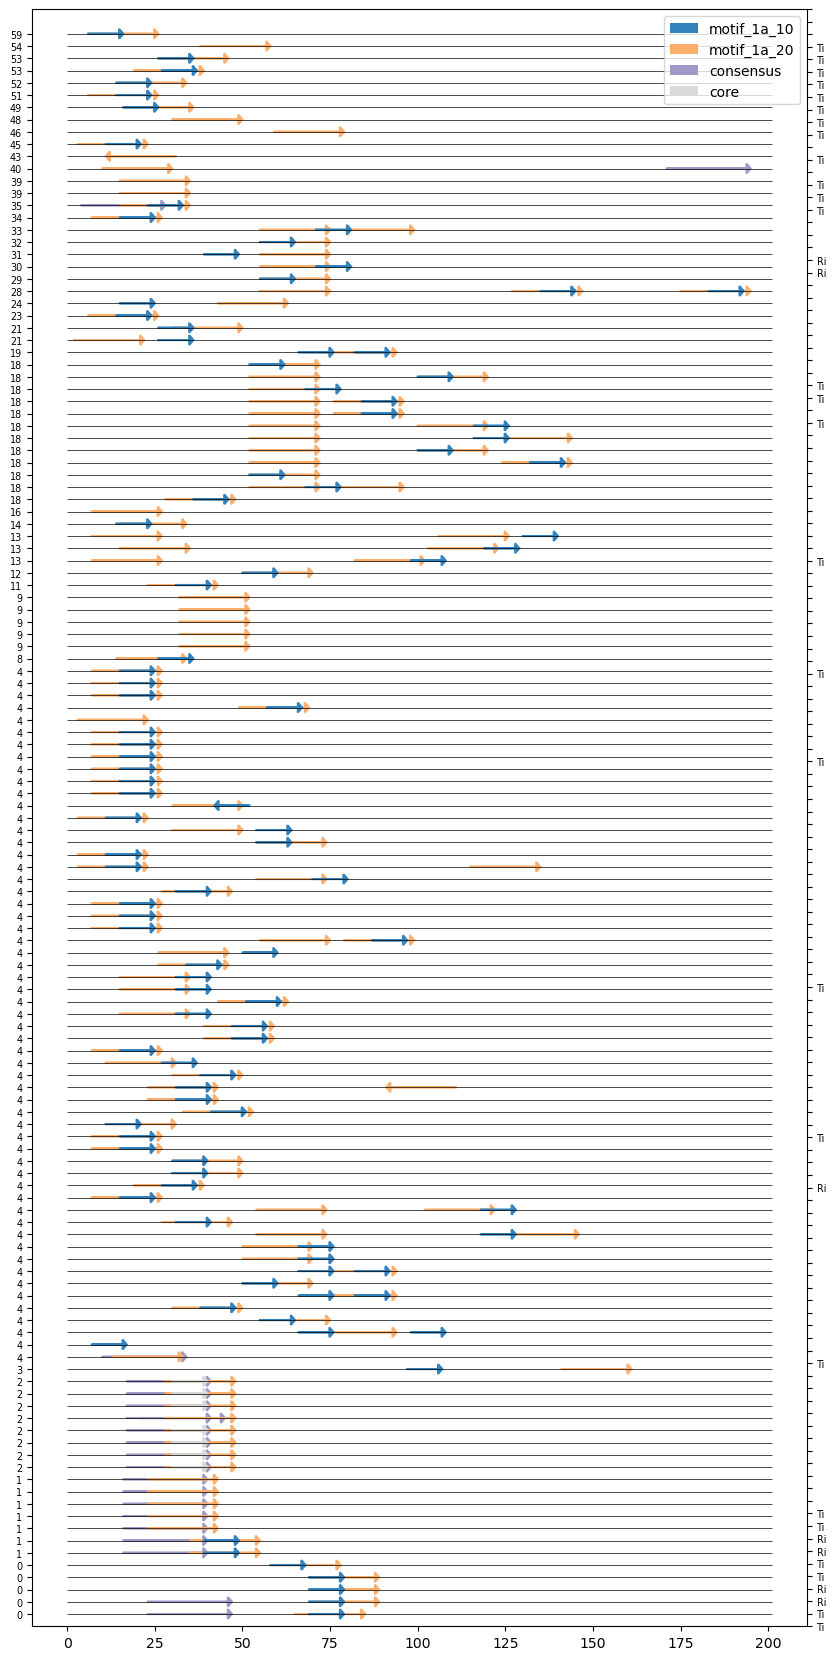

In [327]:

def figure(motif_df:pd.DataFrame):
    
    cmap = mpl.colormaps.get_cmap('tab20c')
    cmap = cmap.resampled(motif_df.motif.nunique())
    palette = {f:cmap(i) for i, f in enumerate(motif_df.motif.unique())} # Map each category to a color. 

    figure_df = motif_df.copy()
    figure_df['group'] = figure_df['id'].map(alignment_group_map)
    figure_df = figure_df.sort_values('group')

    figure_df['plasmid_type'] = figure_df['id'].map(overdrive_df.plasmid_type)
    figure_df['plasmid_class'] = figure_df['id'].map(overdrive_df.plasmid_class)
    # figure_df = figure_df[figure_df.plasmid_class == 'Ri'].copy()
    # figure_df = figure_df[figure_df['id'].isin(strain_a4_overdrive_ids)].copy()


    n = figure_df['id'].nunique()
    print('Num. sequences:', n)

    fig, ax = plt.subplots(figsize=(10, max(1, n//6))) 

    handles, labels = zip(*[(Patch(facecolor=color), label) for label, color in palette.items()])
    ax.legend(handles=handles, labels=labels, loc='upper right')

    y = 0
    x_min, x_max = 0, 201
    y_labels_left = list()
    y_labels_right = list()

    for id_, df in figure_df.groupby('id', sort=False):
        ax.hlines(y, xmax=x_max, xmin=x_min, color='black', lw=0.5)
        df = df.sort_values('length', ascending=False)
        for motif, df_ in df.groupby('motif', sort=False):
            # ax.hlines(y, xmin=df_.start, xmax=df_.stop, color=palette[motif], lw=1.5)

            df_ = df_.sort_values('length', ascending=False)
            for row in df_.itertuples():
                dx = row.length if (row.strand == '+') else -row.length 
                x = row.start if (row.strand == '+') else row.stop 

                lw = (row.significance * 3) if hasattr(row, 'significance') else 1.5
                lw = 1.5 if np.isnan(lw) else lw
                lw = 1.5
                ax.arrow(x, y, dx, 0, length_includes_head=True, color=palette[motif], lw=lw, head_width=0.8, alpha=1)
                
        y_labels_left.append(int(row.group))
        y_labels_right.append('' if (type(row.plasmid_class) != str) else row.plasmid_class)
        y += 1

    ax.set_ylim(ymax=y + 1, ymin=-1)
    ax.set_yticks(np.arange(y), labels=y_labels_left, fontsize='x-small')
    ax.twinx().set_yticks(np.arange(y), labels=y_labels_right[::-1], fontsize='x-small')

    for _, spine in ax.spines.items():
        spine.set_visible(False)


    plt.show()

figure(pd.concat([motif_a_df, consensus_df[consensus_df['id'].isin(motif_a_df['id'])], core_df[core_df['id'].isin(motif_a_df['id'])]]))
# figure(pd.concat([consensus_df[consensus_df['id'].isin(motif_a_df['id'])], core_df[core_df['id'].isin(motif_a_df['id'])]]))
# Might be worth marking all GTTs.
# 
# 25 bp motif best possible match is GCATTTGTTCGTTCGTTCGTTTGTG 
# TAAGTCCCTGTGT[ATGTTTGTTT]G is the consensus sequence  

In [321]:
# def figure(group:int=0):

#     figure_df = pd.concat([df.assign(motif=motif) for motif, df in motif_dfs.items()]) # .iloc[:20]
#     figure_df['group'] = figure_df['id'].map(alignment_group_map)
#     figure_df = figure_df[figure_df.group == group].copy()
#     figure_df['plasmid_type'] = figure_df['id'].map(overdrive_df.plasmid_type)
#     figure_df['plasmid_class'] = figure_df['id'].map(overdrive_df.plasmid_class)
#     n = (overdrive_df.group == group).sum()

#     cmap = mpl.colormaps.get_cmap('tab20c')
#     cmap = cmap.resampled(figure_df.motif.nunique())
#     palette = {f:cmap(i) for i, f in enumerate(figure_df.motif.unique())} # Map each category to a color. 

#     fig, ax = plt.subplots()
#     for motif, df in figure_df.groupby('motif'):
#         counts = np.zeros(202)
#         for row in df.itertuples():
#             motif_idxs = np.arange(row.start, row.stop)
#             counts[motif_idxs] += 1
#         counts = counts / n
#         ax.plot(np.arange(len(counts)), counts, color=palette[motif])

#     text = ''
#     figure_df = figure_df.drop_duplicates('id')
#     # for plasmid_type, df in figure_df[~figure_df.plasmid_type.isnull()].groupby('plasmid_type'):
#     #     text += f'{plasmid_type}: {len(df)}\n'
#     for plasmid_class, df in figure_df[~figure_df.plasmid_class.isnull()].groupby('plasmid_class'):
#         text += f'{plasmid_class}: {len(df)}\n'
#     ax.text(0.5, 0.5, text, transform=ax.transAxes)
    
#     ax.set_title(f'alignment group {group} ($n={n}$)')
#     ax.set_xlabel('position')
#     ax.set_ylabel('proportion')
#     plt.show()
# figure(group=4)
# figure(group=30)
        


In [322]:
for group, df in overdrive_df.groupby('group'):
    if ('Ri' in df.plasmid_class.unique()) and ('Ti' in df.plasmid_class.unique()):
        print(f'Group {int(group)} contains both Ti and Ri plasmids.')

Group 4 contains both Ti and Ri plasmids.


In [323]:
source_ids_without_motifs = overdrive_df[~overdrive_df.motif_1a_10 & ~overdrive_df.motif_1a_20]['source_id'].unique()
source_ids_with_motifs = overdrive_df[overdrive_df.motif_1a_10 | overdrive_df.motif_1a_20]['source_id'].unique()

target_names_without_motifs = overdrive_df[~overdrive_df.motif_1a_10 & ~overdrive_df.motif_1a_20]['contig_id'].unique()
target_names_with_motifs = overdrive_df[overdrive_df.motif_1a_10 | overdrive_df.motif_1a_20]['contig_id'].unique()


np.intersect1d(source_ids_with_motifs, source_ids_without_motifs)
len(np.intersect1d(target_names_without_motifs, target_names_with_motifs))
# len(target_names_without_motifs)

16

In [ ]:
overdrive_no_motifs_df = overdrive_df[~overdrive_df.motif_1a_10 & ~overdrive_df.motif_1a_20].copy()
overdrive_no_motifs_df = overdrive_no_motifs_df[overdrive_no_motifs_df.contig_id.isin(target_names_with_motifs)].copy()
FASTAFile(df=overdrive_no_motifs_df).write('../data/data-2/overdrive_no_motifs.fn')

groups_without_motifs = overdrive_no_motifs_df.group.unique()
groups_with_motifs = overdrive_df[overdrive_df.motif_1a_10 | overdrive_df.motif_1a_20]['group'].unique()

len(np.intersect1d(groups_without_motifs, groups_with_motifs))
overdrive_no_motifs_df[overdrive_no_motifs_df.group.isin(groups_with_motifs)]
print(len(overdrive_no_motifs_df))
FASTAFile(df=overdrive_df[~overdrive_df.motif_1a_10 & ~overdrive_df.motif_1a_20]).write('../data/data-2/overdrive_no_motifs.fn')

42


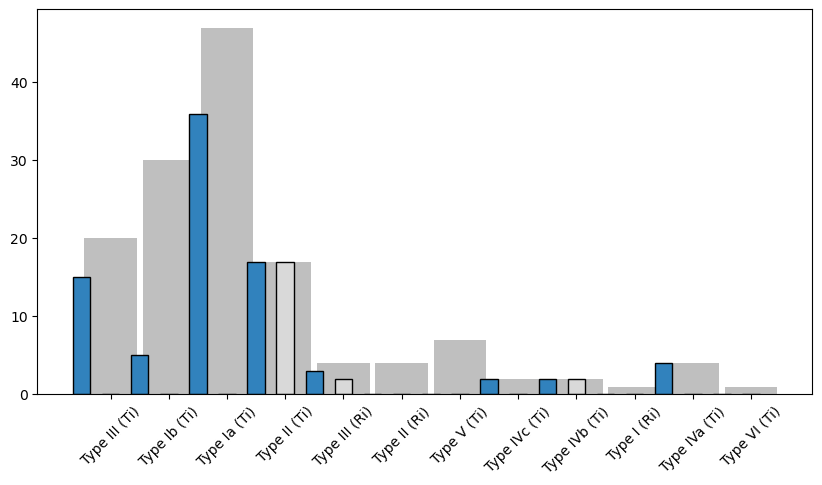

In [324]:
figure_df = overdrive_df.copy()
figure_df = figure_df[~figure_df.plasmid_type.isnull()].copy()

plasmid_types = figure_df.plasmid_type.unique()
totals = [(figure_df.drop_duplicates('source_id').plasmid_type == plasmid_type).sum() for plasmid_type in plasmid_types]

# motifs = [col for col in figure_df.columns if 'motif_1a' in col]
motifs = ['consensus', 'core']
plasmid_types = figure_df.plasmid_type.unique()

cmap = mpl.colormaps.get_cmap('tab20c')
cmap = cmap.resampled(len(motifs))
palette = {f:cmap(i) for i, f in enumerate(motifs)} # Map each category to a color. 


offsets = {motif: (i - 1) * (1 / len(motifs)) for i, motif in enumerate(motifs)}
positions = np.array(np.arange(len(plasmid_types))) + np.mean(list(offsets.values()))

fig, ax = plt.subplots(figsize=(10, 5))
    
# positions = np.arange(len(plasmid_types))
ax.bar(positions, totals, color='gray', alpha=0.5, width=0.9)
for motif in palette.keys():
    df = figure_df[figure_df[f'{motif}']].drop_duplicates('source_id')
    # print(motif, len(df))
    heights = [(df.plasmid_type == plasmid_type).sum() for plasmid_type in plasmid_types]
    # heights = np.array(heights) / np.array(totals)
    ax.bar(positions + offsets[motif], heights, color=palette[motif], width=0.6 / len(motifs), edgecolor='black')

ax.set_xticks(positions, labels=plasmid_types, rotation=45)
plt.show()



In [ ]:
# I should maybe filter for sequnces which have a VirC gene, not just sources. 

# The C-terminal portion of VirC is responsible for DNA binding, and using over this region might help
# reduce issues with evolutionary signal. 

# Would be worth looking at the different "types" of upstream regions to see if there is any consistent difference
# in the DNA binding domain of VirC1. Perhaps some are weaker than others, requiring multiple overdrive-like elements?

# There's not really any data to train a model, so can just start by looking at compositional differences 
# in the binding domain. 

In [ ]:
# # TODO: Look at the relative numbers of right borders and left borders in each fragment to try to determine how many of the 
# # right borders may be duplicated, and therefore have a disrupted upstream region. 

# hmmer_df['has_t_dna'] = has_t_dna(hmmer_df)

# # TODO: Try to map the alignment groups to annotated plasmid types. 

# # Right and left borders are direct repeats, meaning they are on the same strand. They are homologous, but not identical; however
# # they can have 80-90% similarity. The right border sequence is more highly-conserved, which suggests that the HMM may be more prone
# # to labeling a right border as a left border than vice versa (although I can't be sure that the opposite does not occur; indeed, based on the 
# # average number of left and right borders per sequence, it seems as though there are slightly more annotated right borders). 

# # Left borders are generally less conserved, as the right border is where the VirD nick site is. Termination is not as essential; apparently
# # if termination does not occur, then part of the plasmid backbone may end up being transformed. 

# print('Num. unique contigs:', hmmer_df.target_name.nunique())
# print('Num. contigs with both left and right borders:', hmmer_df.drop_duplicates('target_name').has_t_dna.sum())
# # print('Average number of left borders per sequence:', hmmer_df[hmmer_df.query_name == 'T-DNA_left_border'].value_counts('target_name').mean())
# # print('Average number of right borders per sequence:', hmmer_df[hmmer_df.query_name == 'T-DNA_right_border'].value_counts('target_name').mean())

# def has_conflict(row, hmmer_df:pd.DataFrame=hmmer_df):
#     hmmer_df = hmmer_df[hmmer_df.target_name == row.target_name].copy() # Get the hits within the same sequence. 
#     start, stop = min(row.target_from, row.target_to), max(row.target_from, row.target_to)
#     hmmer_df['overlap'] = ~((hmmer_df.start > stop) | (hmmer_df.stop < start) | (hmmer_df.index == row.name))
#     return hmmer_df.overlap.sum() > 0

# def has_left_border(right_border_row, hmmer_df:pd.DataFrame=hmmer_df):
#     mask = (hmmer_df.target_name == row.target_name) & (hmmer_df.strand == row.strand) & (hmmer_df.query_name == 'T-DNA_left_border')
#     if mask.sum() == 0:
#         return False
#     hmmer_df = hmmer_df[mask]
#     start, stop = right_border_row.start, right_border_row.stop
#     n_left_borders = (((hmmer_df.stop < start) & (hmmer_df.strand == '+')) | ((hmmer_df.start > stop) & (hmmer_df.strand == '-'))).sum()
#     return n_left_borders > 0

# right_borders_df = hmmer_df[hmmer_df.query_name == 'T-DNA_right_border'].copy()
# right_borders_df['has_conflict'] =  right_borders_df.apply(has_conflict, axis=1)
# right_borders_df['has_left_border'] =  right_borders_df.apply(has_left_border, axis=1)

# print('Num. right borders:', len(right_borders_df))
# print('Num. right borders with conflict:', right_borders_df.has_conflict.sum())
# print('Num. right borders with a corresponding left border:', right_borders_df.has_left_border.sum())


In [ ]:
# overdrive_df['has_motif_2'] = overdrive_df.index.isin(motif_2_df['id'])
# overdrive_df['has_motif_3'] = overdrive_df.index.isin(motif_3_df['id'])
# overdrive_df['has_motif'] = overdrive_df.has_motif_1 | overdrive_df.has_motif_2 | overdrive_df.has_motif_3

# upstream_length = 15
# downstream_length = 5
# content = ''
# with open('../data/data-2/motif_1a.fn', 'w') as f:
#     for row in motif_1a_df.itertuples():
#         content += f'>{getattr(row, 'id')}\n'
#         content += f'{row.seq[max(0, row.start - upstream_length):row.stop + downstream_length]}\n'
#     f.write(content)

# "Comparison of overdrive sequences flanking several T-DNAs revealed a fully conserved 8-bp core region within the rightmost half of the 
# original overdrive consensus sequence"

# print(f'Num. overdrive sequences with motif 1 ({motif_1}):', overdrive_df.has_motif_1.sum())
# print(f'Num. overdrive sequences with motif 2 ({motif_2}):', overdrive_df.has_motif_2.sum())
# print(f'Num. overdrive sequences with motif 3 ({motif_3}):', overdrive_df.has_motif_3.sum())
# print(f'Num. overdrive sequences with any motif:', (overdrive_df.has_motif_1 | overdrive_df.has_motif_2 | overdrive_df.has_motif_3).sum())


# It seems as though motif 1 is only identified in 461 sequences. I wonder if I can use an HMM to identify more?

# Based on looking at the motifs found by setting the width equal to 20, it seems as though there is more conservation at the 5' end of the 
# short 10 bp motif, as the 3' motif is 

# Results are the same with both the ZOOPS or OOPS assumption. 